In [1]:
import torch
import torch.nn as nn
import numpy as np
from torch.functional import F
import random
from scratch_model import AutoEncoder
from torch.optim import Adam
import pandas as pd
import matplotlib.pyplot as plt
import image_all
# from sklearn.manifold import MDS
# import plotly.express as px
# import plotly.graph_objects as go



<h1>0 = Up | 1 = Down | 2 = Left | 3 = Right

In [2]:
train_sas, test_sas = image_all.get_sas_data()  

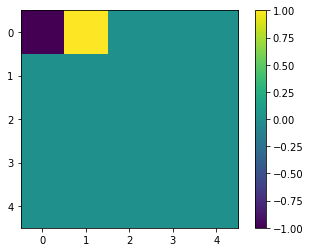

1


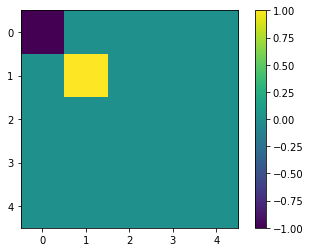

In [3]:
image_all.view_tensor(train_sas[0][0])
print(train_sas[0][1])
image_all.view_tensor(train_sas[0][2])

<h1>Option 2: Latent_tensor to Latent_tensor Loss

In [4]:
in_shape = train_sas[0][0].unsqueeze(0).unsqueeze(0).shape
embed_dim = 64 #Seems like optimal one
enc_dropout = 0
dec_dropout = 0.5
model = AutoEncoder(in_shape, embed_dim,dec_drop_out=dec_dropout, enc_drop_out=enc_dropout)
optimizer = Adam(model.parameters(), lr=1e-4,weight_decay=1e-5)


In [5]:
train_divider = 0.04 * len(train_sas)
test_divider = 0.04 * len(test_sas)
for epoch in range(1000):
    model.train()
    avg_total_loss = 0
    avg_decode_loss = 0
    avg_latent_loss = 0
    for i in random.sample(range(len(train_sas)), len(train_sas)):
        #Prepare Input Data
        input_state, input_action, input_next_state = train_sas[i]
        input_state = input_state.unsqueeze(0).unsqueeze(0)
        input_next_state = input_next_state.unsqueeze(0).unsqueeze(0)
        #Get Model Output
        decoded_init_state, latent_init_state, latent_next_state = model(input_state,input_action,input_next_state,option=2)
        #Calculate Loss
        decode_loss = F.mse_loss(decoded_init_state.squeeze(0).squeeze(0), train_sas[i][0])
        latent_loss = F.mse_loss(latent_init_state,latent_next_state)
        total_loss = decode_loss + latent_loss
        #Add Loss to Average
        avg_decode_loss += decode_loss.item()
        avg_latent_loss += latent_loss.item()
        avg_total_loss += total_loss.item()
        #Backpropagate
        optimizer.zero_grad()
        total_loss.backward()
        optimizer.step()

    if epoch % 10 == 0:
        val_avg_total_loss = 0
        val_avg_decode_loss = 0
        val_avg_latent_loss = 0
    
        for i in random.sample(range(len(test_sas)), len(test_sas)):
            model.eval()
            with torch.no_grad():
                input_state, input_action, input_next_state = test_sas[i]
                input_state = input_state.unsqueeze(0).unsqueeze(0)
                input_next_state = input_next_state.unsqueeze(0).unsqueeze(0)
                decoded_init_state, latent_init_state, latent_next_state = model(input_state,input_action,input_next_state)
                val_decode_loss = F.mse_loss(decoded_init_state.squeeze(0).squeeze(0), test_sas[i][0])
                val_latent_loss = F.mse_loss(latent_init_state,latent_next_state)
                val_total_loss = val_decode_loss + val_latent_loss
                val_avg_decode_loss += val_decode_loss.item()
                val_avg_latent_loss += val_latent_loss.item()
                val_avg_total_loss += val_total_loss.item()
        print(f"{epoch}\nTotal Val Loss: {val_avg_total_loss/test_divider} Decode Val Loss: {val_avg_decode_loss/test_divider} Latent Val Loss: {val_avg_latent_loss/test_divider}")
    print(f"Total Train Loss: {avg_total_loss/train_divider} Decode Train Loss: {avg_decode_loss/train_divider} Latent Train Loss: {avg_latent_loss/train_divider}")


Total Val Loss: 2.199942947507066 Decode Val Loss: 1.9641600071412064 Latent Val Loss: 0.2357829406632252
Total Train Loss: 2.636536697577685 Decode Train Loss: 2.2924848715774715 Latent Train Loss: 0.3440518256436917
Total Train Loss: 1.8779844434000552 Decode Train Loss: 1.7229230295866729 Latent Train Loss: 0.1550614116523775
Total Train Loss: 1.7194236934650688 Decode Train Loss: 1.5397071625571699 Latent Train Loss: 0.17971652953847297
Total Train Loss: 1.556259404728189 Decode Train Loss: 1.3550623974762857 Latent Train Loss: 0.2011970076712714
Total Train Loss: 1.4451860963366925 Decode Train Loss: 1.2375999459763989 Latent Train Loss: 0.2075861509364131
Total Train Loss: 1.3472254652529956 Decode Train Loss: 1.1423913299571722 Latent Train Loss: 0.2048341373938456
Total Train Loss: 1.2488282760139555 Decode Train Loss: 1.0387570976046845 Latent Train Loss: 0.21007118039210582
Total Train Loss: 1.1704845879692585 Decode Train Loss: 0.9637024175608531 Latent Train Loss: 0.206782

KeyboardInterrupt: 

In [11]:
#find good example of agent in the middle. Plug in each action and view decoded tensor. Also check with valid data
train_sas[100] # good example 
test_init_state = train_sas[100][0].unsqueeze(0).unsqueeze(0)
test_next_state = train_sas[100][2].unsqueeze(0).unsqueeze(0)

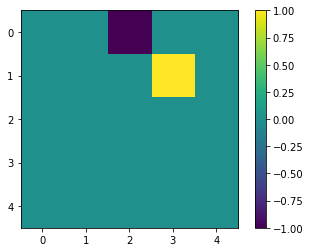

In [12]:
image_all.view_tensor(train_sas[100][0])

Decoded Tensor


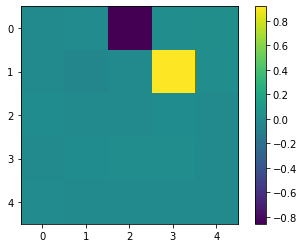

Action: 0


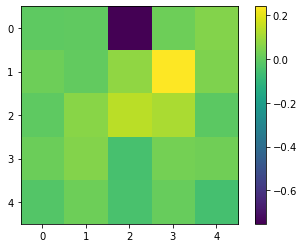

Action: 1


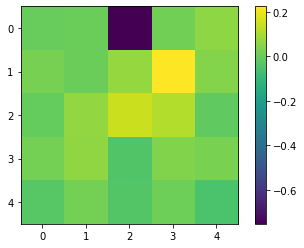

Action: 2


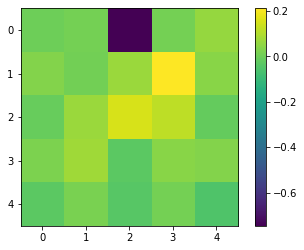

Action: 3


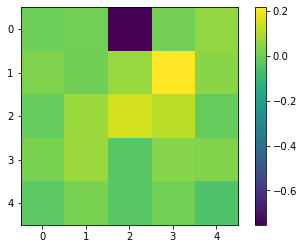

In [15]:
model.eval()
with torch.no_grad():
    decoded_init_state_0, latent_init_state_0, latent_next_state_0 = model(test_init_state,0,test_next_state)
    decoded_init_state_1, latent_init_state_1, latent_next_state_1 = model(test_init_state,1,test_next_state)
    decoded_init_state_2, latent_init_state_2, latent_next_state_2 = model(test_init_state,2,test_next_state)
    decoded_init_state_3, latent_init_state_3, latent_next_state_3 = model(test_init_state,3,test_next_state)
#Decoded Tensor
print('Decoded Tensor')
image_all.view_tensor(decoded_init_state_0.squeeze(0).squeeze(0))
for latent_tensor, a in zip([latent_init_state_0,latent_init_state_1,latent_init_state_2,latent_init_state_3],range(4)):
    print('Action:',a)
    image_all.view_tensor(model.decoder(latent_tensor).squeeze(0).squeeze(0).detach())
